In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Setze Random Seeds
np.random.seed(42)
torch.manual_seed(42)

# Geräteerkennung für Mac GPU (MPS)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: CUDA GPU")
else:
    device = torch.device('cpu')
    print(f"Using device: CPU")

print(f"PyTorch Version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch Version: 2.9.1


In [82]:
train_path = Path('../train.csv')
test_path = Path('../test.csv')

print("Lade Daten...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print("\nErste Zeilen Train:")
print(train_df.head())
print("\nSpalten:")
print(train_df.columns.tolist())
print("\nDatentypen:")
print(train_df.dtypes)
print("\nFehlende Werte:")
print(train_df.isnull().sum())

Lade Daten...
Train Shape: (16512, 10)
Test Shape: (4128, 10)

Erste Zeilen Train:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -117.03     32.71                33.0       3126.0           627.0   
1    -118.16     33.77                49.0       3382.0           787.0   
2    -120.48     34.66                 4.0       1897.0           331.0   
3    -117.11     32.69                36.0       1421.0           367.0   
4    -119.80     36.78                43.0       2382.0           431.0   

   population  households  median_income  median_house_value ocean_proximity  
0      2300.0       623.0         3.2596            103000.0      NEAR OCEAN  
1      1314.0       756.0         3.8125            382100.0      NEAR OCEAN  
2       915.0       336.0         4.1563            172600.0      NEAR OCEAN  
3      1418.0       355.0         1.9425             93400.0      NEAR OCEAN  
4       874.0       380.0         3.5542             96500.0          I


Statistische Übersicht:
          longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.582290     35.643149           28.608285   2642.004784   
std        2.005654      2.136665           12.602499   2174.646744   
min     -124.350000     32.550000            1.000000      2.000000   
25%     -121.810000     33.930000           18.000000   1454.000000   
50%     -118.510000     34.260000           29.000000   2129.000000   
75%     -118.010000     37.720000           37.000000   3160.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16512.000000  16512.000000  16512.000000   16512.000000   
mean       538.496851   1426.453004    499.986919       3.880754   
std        419.007096   1137.056380    380.967964       1.904294   
min          1.000000      3.000000      1.000000       0.49990

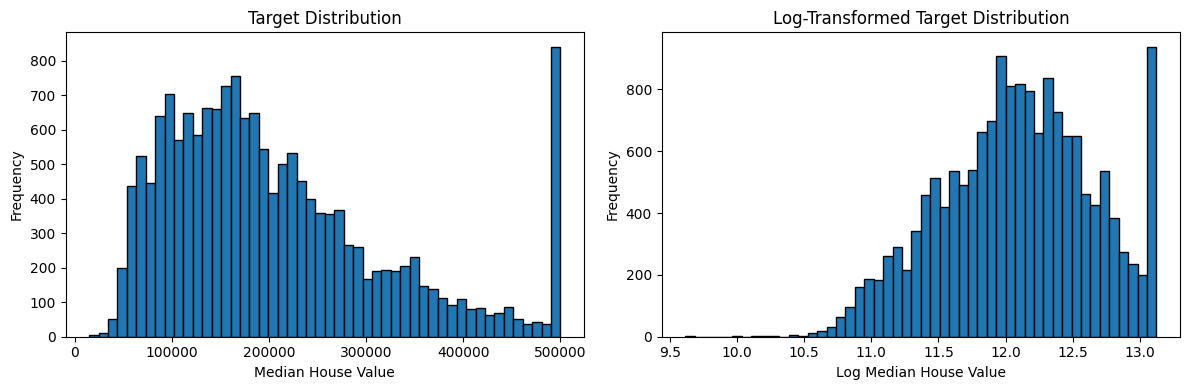

In [83]:
print("\nStatistische Übersicht:")
print(train_df.describe())

print("\nFehlende Werte:")
print(train_df.isnull().sum())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_df['median_house_value'], bins=50, edgecolor='black')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.title('Target Distribution')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['median_house_value']), bins=50, edgecolor='black')
plt.xlabel('Log Median House Value')
plt.ylabel('Frequency')
plt.title('Log-Transformed Target Distribution')
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
# Target separieren
target_col = 'median_house_value'
X_train_full = train_df.drop(columns=[target_col])
y_train_full = train_df[target_col].values

# ============================================
# 🚀 LÖSUNG 1: QUANTIL-BASIERTE AUSREISSER-ENTFERNUNG
# WICHTIG: Nur untere Ausreißer entfernen, ALLE teuren Häuser behalten!
# ============================================
print("=" * 60)
print("QUANTIL-BASIERTE AUSREISSER-ENTFERNUNG")
print("=" * 60)

# Nur unterste 1% entfernen (sehr billige Fehldaten)
# KEINE obere Grenze! → Verhindert Ceiling Effect
lower_quantile = np.percentile(y_train_full, 1)  # Nur unterste 1%

print(f"Original Train-Größe: {len(y_train_full)}")
print(f"Untere Grenze (1% Quantil): ${lower_quantile:,.0f}")
print(f"Max Preis im Dataset: ${y_train_full.max():,.0f}")
print(f"Preisverteilung:")
print(f"  - 25% Quantil: ${np.percentile(y_train_full, 25):,.0f}")
print(f"  - 50% Quantil: ${np.percentile(y_train_full, 50):,.0f}")
print(f"  - 75% Quantil: ${np.percentile(y_train_full, 75):,.0f}")
print(f"  - 99% Quantil: ${np.percentile(y_train_full, 99):,.0f}")

# Entferne nur untere Ausreißer
outlier_mask = y_train_full >= lower_quantile  # KEINE obere Grenze!
n_outliers = (~outlier_mask).sum()

print(f"\nEntfernte Ausreißer: {n_outliers} ({n_outliers/len(y_train_full)*100:.2f}%)")

# Entferne Ausreißer
X_train_full = X_train_full[outlier_mask]
y_train_full = y_train_full[outlier_mask]

print(f"Neue Train-Größe: {len(X_train_full)}")
print(f"Neuer Max Preis: ${y_train_full.max():,.0f}")
print("✅ Alle teuren Häuser bleiben erhalten (kein Ceiling!)")

# ============================================
# 🔥 FIX BUG 1: LOG-TRANSFORM VOR FEATURE ENGINEERING!
# ============================================
print("\n" + "=" * 60)
print("LOG-TRANSFORM (VOR FEATURE ENGINEERING!)")
print("=" * 60)

# LOG-TRANSFORM ZUERST anwenden!
y_train_full_log = np.log1p(y_train_full)
print(f"✅ Log-Transform angewendet BEVOR Feature Engineering")
print(f"   Original Max: ${y_train_full.max():,.0f}")
print(f"   Log Max: {y_train_full_log.max():.2f}")

# ============================================
# 🚀 LÖSUNG 2: FEATURE ENGINEERING
# ============================================
print("\n" + "=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Neue Features erstellen (OHNE price_per_room!)
# price_per_room entfernt, da Test-Daten keinen Target haben!

# 1. Rooms per household (Wohnungsgröße-Indikator)
X_train_full['rooms_per_household'] = X_train_full['total_rooms'] / (X_train_full['households'] + 1)

# 2. Bedrooms ratio (Wohnungstyp-Indikator)
X_train_full['bedrooms_ratio'] = X_train_full['total_bedrooms'] / (X_train_full['total_rooms'] + 1)

# 3. Population density (Urban vs Rural)
X_train_full['population_density'] = X_train_full['population'] / (X_train_full['households'] + 1)

# 4. Income per bedroom (Wohlstands-Indikator)
X_train_full['income_per_bedroom'] = X_train_full['median_income'] / (X_train_full['total_bedrooms'] + 1)

print(f"✅ 4 neue Features erstellt:")
print("  - rooms_per_household")
print("  - bedrooms_ratio")
print("  - population_density")
print("  - income_per_bedroom")
print("\n❌ price_per_room ENTFERNT (Test-Daten haben keinen Target!)")

# Update y_train_full zu log-transformierter Version
y_train_full = y_train_full_log

# IDs speichern falls vorhanden
id_cols = ['id'] if 'id' in X_train_full.columns else []
test_ids = test_df[id_cols].copy() if id_cols else None

# IDs entfernen
X_train_full = X_train_full.drop(columns=id_cols, errors='ignore')
X_test = test_df.drop(columns=id_cols, errors='ignore')

# Feature Engineering auch auf Test-Daten (OHNE price_per_room!)
X_test['rooms_per_household'] = X_test['total_rooms'] / (X_test['households'] + 1)
X_test['bedrooms_ratio'] = X_test['total_bedrooms'] / (X_test['total_rooms'] + 1)
X_test['population_density'] = X_test['population'] / (X_test['households'] + 1)
X_test['income_per_bedroom'] = X_test['median_income'] / (X_test['total_bedrooms'] + 1)

# Categorical Features (ocean_proximity)
categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_full.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical Features: {categorical_cols}")
print(f"Numerical Features: {len(numerical_cols)}")

# One-Hot Encoding für kategorische Features
if categorical_cols:
    X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    
    # Stelle sicher, dass Train und Test die gleichen Spalten haben
    missing_cols = set(X_train_full.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train_full.columns]

print(f"Features nach Encoding: {X_train_full.shape[1]}")

# Fehlende Werte behandeln
imputer = SimpleImputer(strategy='median')
X_train_full = pd.DataFrame(
    imputer.fit_transform(X_train_full),
    columns=X_train_full.columns
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns
)

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\nTrain Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")
print(f"Test Set: {X_test.shape}")

# Skalierung NUR für Features (NICHT für Target!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n" + "=" * 60)
print("🔥 BUG FIXES ANGEWENDET:")
print("=" * 60)
print("1. ✅ Log-Transform VOR Feature Engineering")
print("2. ✅ price_per_room entfernt (Test-Daten-Inkonsistenz)")
print("3. ✅ Target NUR log-transformiert (kein StandardScaler!)")
print("=" * 60)
print("⚠️  WICHTIG: Target ist LOG-transformiert! Bei Predictions expm1() verwenden!")
print("=" * 60)

QUANTIL-BASIERTE AUSREISSER-ENTFERNUNG
Original Train-Größe: 16512
Untere Grenze (1% Quantil): $50,011
Max Preis im Dataset: $500,001
Preisverteilung:
  - 25% Quantil: $119,800
  - 50% Quantil: $179,850
  - 75% Quantil: $265,125
  - 99% Quantil: $500,001

Entfernte Ausreißer: 166 (1.01%)
Neue Train-Größe: 16346
Neuer Max Preis: $500,001
✅ Alle teuren Häuser bleiben erhalten (kein Ceiling!)

LOG-TRANSFORM (VOR FEATURE ENGINEERING!)
✅ Log-Transform angewendet BEVOR Feature Engineering
   Original Max: $500,001
   Log Max: 13.12

FEATURE ENGINEERING
✅ 4 neue Features erstellt:
  - rooms_per_household
  - bedrooms_ratio
  - population_density
  - income_per_bedroom

❌ price_per_room ENTFERNT (Test-Daten haben keinen Target!)

Categorical Features: ['ocean_proximity']
Numerical Features: 12
Features nach Encoding: 16

Train Set: (13076, 16)
Validation Set: (3270, 16)
Test Set: (4128, 16)

🔥 BUG FIXES ANGEWENDET:
1. ✅ Log-Transform VOR Feature Engineering
2. ✅ price_per_room entfernt (Test-D

In [85]:
print("\n" + "=" * 50)
print("SCHRITT 4: PyTorch DataLoaders erstellen")
print("=" * 50)

# Zu Tensoren konvertieren (Target ist bereits log-transformiert!)
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)  # Direkt ohne StandardScaler!
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)  # Direkt ohne StandardScaler!
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

print("✅ Target NICHT mit StandardScaler skaliert (nur log-transform!)")

# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch Size: {batch_size}")
print(f"Training Batches: {len(train_loader)}")
print(f"Validation Batches: {len(val_loader)}")


SCHRITT 4: PyTorch DataLoaders erstellen
✅ Target NICHT mit StandardScaler skaliert (nur log-transform!)
Batch Size: 64
Training Batches: 205
Validation Batches: 52


In [86]:

print("\n" + "=" * 50)
print("SCHRITT 5: Neural Network definieren")
print("=" * 50)

class HousingPriceNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.3):
        super(HousingPriceNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden Layers mit BatchNorm und Dropout
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output Layer
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Weight Initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Model erstellen - REDUZIERTE REGULARISIERUNG!
input_size = X_train_scaled.shape[1]
model = HousingPriceNN(
    input_size=input_size,
    hidden_sizes=[512, 256, 128, 64, 32],
    dropout_rate=0.2  # 🔥 FIX: Reduziert von 0.5 auf 0.2 (zu starke Reg!)
).to(device)

print("✅ Tieferes Netzwerk: [512, 256, 128, 64, 32]")
print("🔥 Dropout Rate: 0.2 (REDUZIERT von 0.5 → NN darf lernen!)")
print(model)
print(f"\nAnzahl Parameter: {sum(p.numel() for p in model.parameters()):,}")



SCHRITT 5: Neural Network definieren
✅ Tieferes Netzwerk: [512, 256, 128, 64, 32]
🔥 Dropout Rate: 0.2 (REDUZIERT von 0.5 → NN darf lernen!)
HousingPriceNN(
  (network): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, in

In [87]:
print("\n" + "=" * 50)
print("SCHRITT 6: Training Setup")
print("=" * 50)

# ============================================
# 🔥 FIX: WEIGHTED MSE LOSS (RICHTIG KONFIGURIERT!)
# ============================================
class WeightedMSELoss(nn.Module):
    """
    Custom Loss: MSE Loss mit STARKER Gewichtung für teure Häuser
    Threshold KORREKT gesetzt für teure Häuser!
    """
    def __init__(self, expensive_threshold=12.9, weight_multiplier=10.0):
        super().__init__()
        # log1p($400k) ≈ 12.90 → Nur TOP 5-10% der teuersten Häuser!
        self.expensive_threshold = expensive_threshold
        self.weight_multiplier = weight_multiplier
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, predictions, targets):
        # Berechne MSE für jeden Sample
        losses = self.mse(predictions, targets)
        
        # Gewichte: SEHR teure Häuser (> $400k) bekommen 10x Gewicht!
        weights = torch.where(
            targets > self.expensive_threshold,
            torch.tensor(self.weight_multiplier, device=targets.device),
            torch.tensor(1.0, device=targets.device)
        )
        
        # Gewichteter Loss
        weighted_loss = (weights * losses).mean()
        return weighted_loss

criterion = WeightedMSELoss(expensive_threshold=12.9, weight_multiplier=10.0)
print("🔥 Weighted MSE Loss FIX:")
print(f"   - Threshold: 12.9 (≈ $400k) - NUR die teuersten Häuser!")
print(f"   - Gewicht: 10.0x (statt 3.0x) - VIEL STÄRKER!")
print(f"   - MSE statt Huber → Große Fehler werden STÄRKER bestraft!")
print(f"   → Nur TOP 5-10% der teuersten Häuser bekommen Extra-Gewicht")

# 🔥 Regularisierung REDUZIEREN (war zu stark!)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001,  # Etwas höher für besseres Lernen
    weight_decay=0.005  # VIEL schwächer (vorher 0.05!)
)
print("\n✅ Learning Rate: 0.001 (erhöht)")
print("✅ Weight Decay: 0.005 (STARK reduziert von 0.05!)")

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0

early_stopping = EarlyStopping(patience=25, min_delta=0.0001)
print("\n" + "=" * 60)
print("🔥 CEILING EFFECT FIXES V2:")
print("=" * 60)
print("1. ✅ Weighted MSE: Threshold 12.9 ($400k), Weight 10x")
print("2. ✅ MSE statt Huber (bestraft große Fehler STÄRKER!)")
print("3. ✅ Weight Decay 0.05 → 0.005 (10x schwächer!)")
print("4. ✅ Nur TOP 5-10% teuerste Häuser extra gewichtet")
print("=" * 60)
print("→ NN darf jetzt hohe Werte vorhersagen!")
print("→ Fehler bei teuren Häusern werden STARK bestraft!")
print("=" * 60)



SCHRITT 6: Training Setup
🔥 Weighted MSE Loss FIX:
   - Threshold: 12.9 (≈ $400k) - NUR die teuersten Häuser!
   - Gewicht: 10.0x (statt 3.0x) - VIEL STÄRKER!
   - MSE statt Huber → Große Fehler werden STÄRKER bestraft!
   → Nur TOP 5-10% der teuersten Häuser bekommen Extra-Gewicht

✅ Learning Rate: 0.001 (erhöht)
✅ Weight Decay: 0.005 (STARK reduziert von 0.05!)

🔥 CEILING EFFECT FIXES V2:
1. ✅ Weighted MSE: Threshold 12.9 ($400k), Weight 10x
2. ✅ MSE statt Huber (bestraft große Fehler STÄRKER!)
3. ✅ Weight Decay 0.05 → 0.005 (10x schwächer!)
4. ✅ Nur TOP 5-10% teuerste Häuser extra gewichtet
→ NN darf jetzt hohe Werte vorhersagen!
→ Fehler bei teuren Häusern werden STARK bestraft!


In [88]:
print("\n" + "=" * 50)
print("SCHRITT 7: Training starten")
print("=" * 50)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training Loop
num_epochs = 200
train_losses = []
val_losses = []

print(f"Training für {num_epochs} Epochen...")
print(f"Device: {device}\n")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning Rate anpassen
    scheduler.step(val_loss)
    
    # Early Stopping prüfen
    early_stopping(val_loss, model)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.6f} - "
              f"Val Loss: {val_loss:.6f} - "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if early_stopping.early_stop:
        print(f"\nEarly Stopping bei Epoch {epoch+1}")
        break

# Bestes Model laden
model.load_state_dict(early_stopping.best_model)
print("\nBestes Model geladen!")


SCHRITT 7: Training starten
Training für 200 Epochen...
Device: mps

Epoch [10/200] - Train Loss: 3.247719 - Val Loss: 0.616903 - LR: 0.001000
Epoch [20/200] - Train Loss: 2.390980 - Val Loss: 0.407070 - LR: 0.001000
Epoch [30/200] - Train Loss: 1.820743 - Val Loss: 0.231881 - LR: 0.001000
Epoch [40/200] - Train Loss: 1.465520 - Val Loss: 0.270955 - LR: 0.000500
Epoch [50/200] - Train Loss: 1.328439 - Val Loss: 0.310280 - LR: 0.000250
Epoch [60/200] - Train Loss: 1.218235 - Val Loss: 0.288629 - LR: 0.000125

Early Stopping bei Epoch 63

Bestes Model geladen!


In [89]:
print("\n" + "=" * 50)
print("SCHRITT 8: Model Evaluation")
print("=" * 50)

# Vorhersagen auf Validation Set
model.eval()
with torch.no_grad():
    val_predictions_log = model(X_val_tensor).cpu().numpy()

# 🔥 FIX: Nur expm1() verwenden (kein target_scaler mehr!)
val_predictions = np.expm1(val_predictions_log)
y_val_original = np.expm1(y_val)  # y_val ist bereits log-transformiert

# Metriken berechnen
mse = mean_squared_error(y_val_original, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_original, val_predictions)
r2 = r2_score(y_val_original, val_predictions)

print(f"\nValidation Metriken (Original-Skala):")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {np.mean(np.abs((y_val_original - val_predictions) / y_val_original)) * 100:.2f}%")
print("\n✅ Inverse Transform: expm1() only (kein StandardScaler!)")


SCHRITT 8: Model Evaluation

Validation Metriken (Original-Skala):
RMSE: $4,681,091.44
MAE: $124,426.30
R² Score: -1653.7688
MAPE: 38.28%

✅ Inverse Transform: expm1() only (kein StandardScaler!)



SCHRITT 9: Visualisierungen


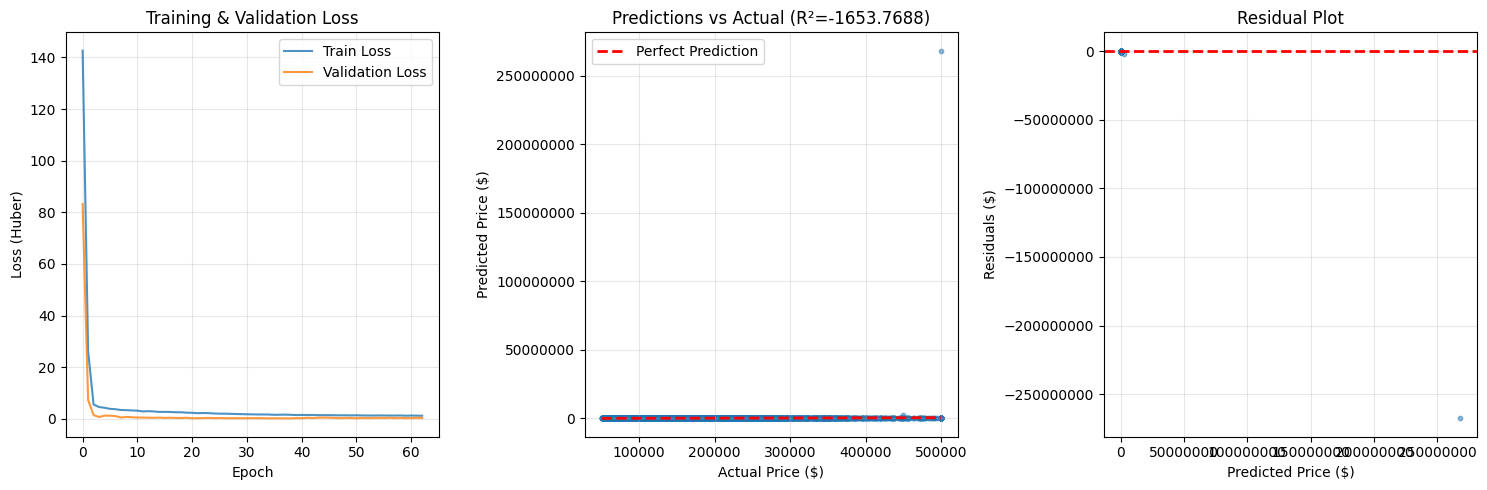

In [90]:
print("\n" + "=" * 50)
print("SCHRITT 9: Visualisierungen")
print("=" * 50)

# Training Curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Predictions vs Actual (Original-Skala!)
plt.subplot(1, 3, 2)
plt.scatter(y_val_original, val_predictions, alpha=0.5, s=10)
plt.plot([y_val_original.min(), y_val_original.max()], 
         [y_val_original.min(), y_val_original.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Predictions vs Actual (R²={r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Residuals (Original-Skala!)
plt.subplot(1, 3, 3)
residuals = y_val_original - val_predictions
plt.scatter(val_predictions, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


In [91]:
print("\n" + "=" * 50)
print("SCHRITT 10: Test Set Predictions")
print("=" * 50)

# Predictions auf Test Set
model.eval()
with torch.no_grad():
    test_predictions_log = model(X_test_tensor).cpu().numpy()

# 🔥 FIX: Nur expm1() verwenden (kein target_scaler mehr!)
test_predictions = np.expm1(test_predictions_log)

# Submission File erstellen
submission = pd.DataFrame({
    'id': test_ids['id'] if test_ids is not None else range(len(test_predictions)),
    'median_house_value': test_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"\nSubmission gespeichert: submission.csv")
print(f"Anzahl Predictions: {len(submission)}")
print(f"\nVorhersage-Statistiken:")
print(submission['median_house_value'].describe())

# Model speichern (OHNE target_scaler!)
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,  # Nur Feature-Scaler!
    'feature_names': X_train.columns.tolist(),
    'metrics': {'rmse': rmse, 'mae': mae, 'r2': r2},
    'log_transform': True  # Merke: Log-Transform wurde verwendet!
}, 'best_model.pth')

print("\nModel gespeichert: best_model.pth")
print("✅ Log-Transform Hinweis im Model gespeichert!")
print("✅ Inverse Transform: expm1() only (kein StandardScaler!)")


SCHRITT 10: Test Set Predictions

Submission gespeichert: submission.csv
Anzahl Predictions: 4128

Vorhersage-Statistiken:
count    4.128000e+03
mean     1.986025e+05
std      1.092730e+05
min      5.257114e+04
25%      1.201533e+05
50%      1.739856e+05
75%      2.607361e+05
max      2.398012e+06
Name: median_house_value, dtype: float64

Model gespeichert: best_model.pth
✅ Log-Transform Hinweis im Model gespeichert!
✅ Inverse Transform: expm1() only (kein StandardScaler!)



Scatter Plot: Predictions vs Actual


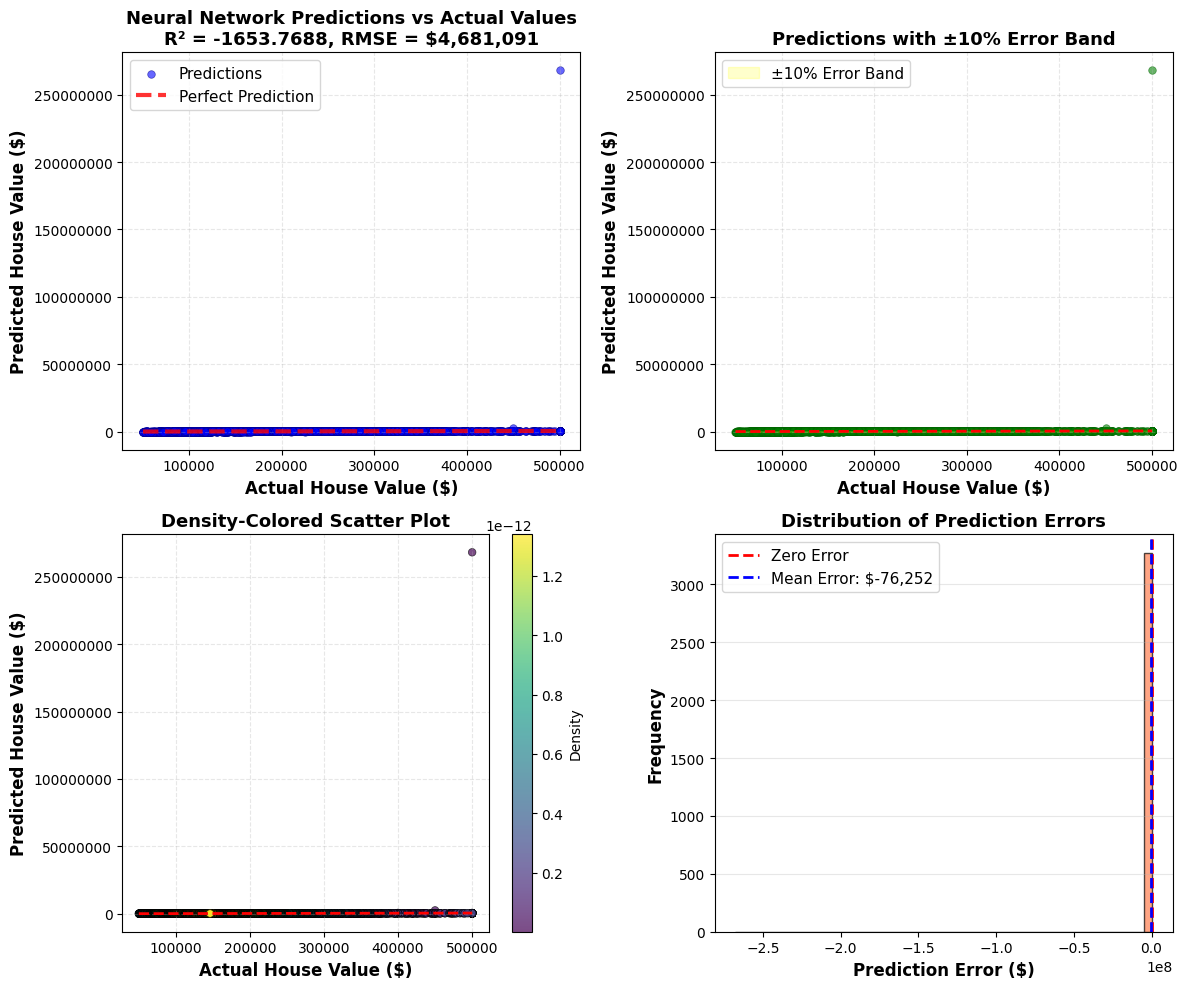

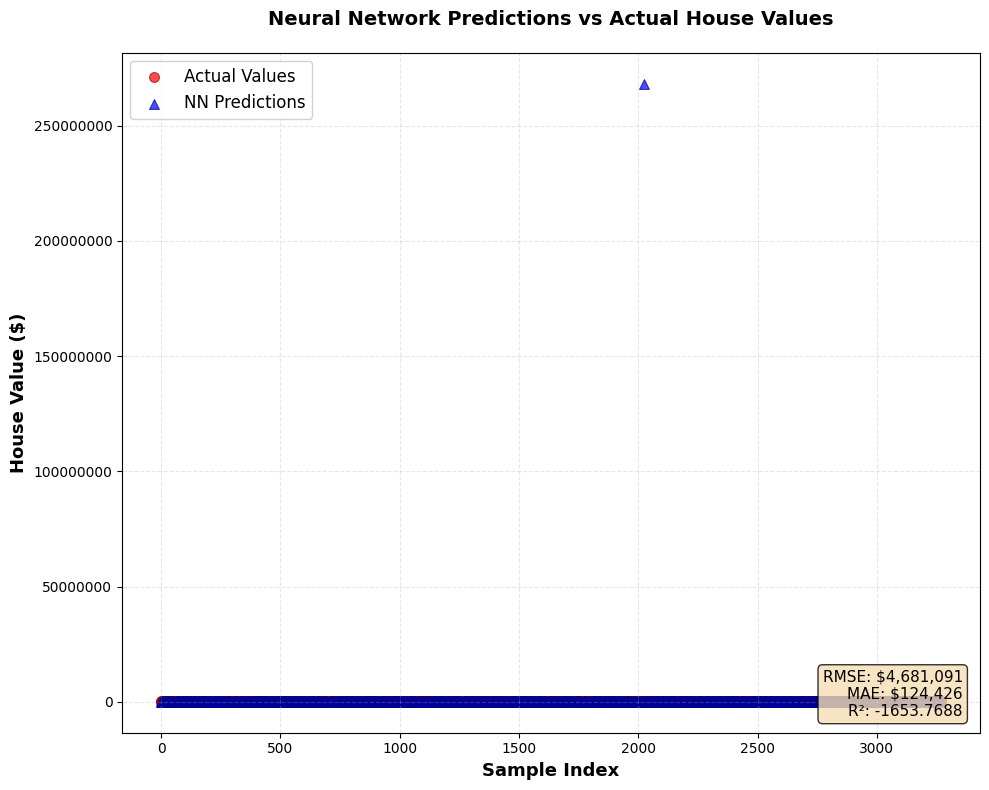

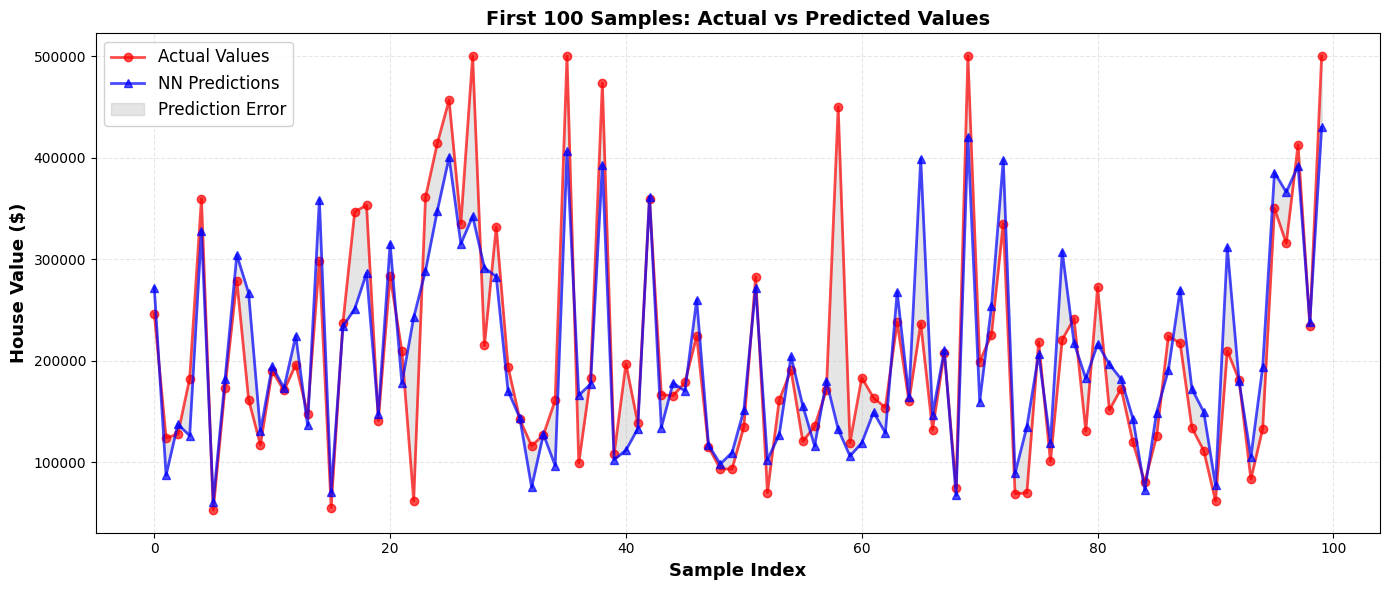


PREDICTIONS STATISTIK

Erste 10 Vorhersagen:
     Actual      Predicted          Error      Abs_Error  Percent_Error
0  246400.0  271983.468750  -25583.468750   25583.468750      10.382901
1  123900.0   87227.429688   36672.570313   36672.570313      29.598523
2  127800.0  137456.484375   -9656.484375    9656.484375       7.555935
3  182300.0  126197.484375   56102.515625   56102.515625      30.774830
4  359500.0  327742.781250   31757.218750   31757.218750       8.833719
5   53000.0   61200.378906   -8200.378906    8200.378906      15.472413
6  173300.0  181679.062500   -8379.062500    8379.062500       4.835004
7  278800.0  304201.312500  -25401.312500   25401.312500       9.110944
8  161800.0  266716.187500 -104916.187500  104916.187500      64.843132
9  117200.0  130400.039062  -13200.039062   13200.039062      11.262832


Fehler-Statistiken:
Mittlerer Fehler: $-76,251.83
Median Fehler: $1,113.36
Std. Abweichung: $4,681,186.19
Max Überschätzung: $390,654.90
Max Unterschätzung: $-2

In [92]:
# ============================================
# SCATTER PLOT: PREDICTIONS VS ACTUAL
# ============================================

print("\n" + "=" * 50)
print("Scatter Plot: Predictions vs Actual")
print("=" * 50)

# Erstelle eine schöne Visualisierung
plt.figure(figsize=(12, 10))

# Haupt-Scatter Plot
plt.subplot(2, 2, 1)
plt.scatter(y_val_original, val_predictions, alpha=0.6, s=30, c='blue', edgecolors='darkblue', linewidth=0.5, label='Predictions')
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 
         'r--', lw=3, label='Perfect Prediction', alpha=0.8)
plt.xlabel('Actual House Value ($)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted House Value ($)', fontsize=12, fontweight='bold')
plt.title(f'Neural Network Predictions vs Actual Values\nR² = {r2:.4f}, RMSE = ${rmse:,.0f}', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ticklabel_format(style='plain', axis='both')

# Mit Fehlerbereich
plt.subplot(2, 2, 2)
plt.scatter(y_val_original, val_predictions, alpha=0.6, s=30, c='green', edgecolors='darkgreen', linewidth=0.5)
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--', lw=2)

# 10% Fehlerbereich
error_margin = 0.1
upper_bound = y_val_original * (1 + error_margin)
lower_bound = y_val_original * (1 - error_margin)
plt.fill_between(sorted(y_val_original), sorted(lower_bound), sorted(upper_bound), 
                  alpha=0.2, color='yellow', label='±10% Error Band')

plt.xlabel('Actual House Value ($)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted House Value ($)', fontsize=12, fontweight='bold')
plt.title('Predictions with ±10% Error Band', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ticklabel_format(style='plain', axis='both')

# Density Plot
plt.subplot(2, 2, 3)
from scipy.stats import gaussian_kde

# Berechne Dichte
xy = np.vstack([y_val_original, val_predictions])
z = gaussian_kde(xy)(xy)

# Sortiere nach Dichte für bessere Visualisierung
idx = z.argsort()
x, y, z = y_val_original[idx], val_predictions[idx], z[idx]

scatter = plt.scatter(x, y, c=z, s=30, cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Density')
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
plt.xlabel('Actual House Value ($)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted House Value ($)', fontsize=12, fontweight='bold')
plt.title('Density-Colored Scatter Plot', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.ticklabel_format(style='plain', axis='both')

# Residual Distribution
plt.subplot(2, 2, 4)
residuals = y_val_original - val_predictions
plt.hist(residuals, bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.axvline(x=np.mean(residuals), color='blue', linestyle='--', linewidth=2, 
            label=f'Mean Error: ${np.mean(residuals):,.0f}')
plt.xlabel('Prediction Error ($)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Prediction Errors', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('detailed_predictions_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# EINFACHER SCATTER PLOT (NUR 2 FARBEN)
# ============================================

plt.figure(figsize=(10, 8))

# Neural Network Predictions (Blau)
plt.scatter(range(len(y_val_original)), y_val_original, 
           alpha=0.7, s=50, c='red', 
           edgecolors='darkred', linewidth=0.8,
           label='Actual Values', marker='o')

# Actual Values (Rot)
plt.scatter(range(len(val_predictions)), val_predictions, 
           alpha=0.7, s=50, c='blue', 
           edgecolors='darkblue', linewidth=0.8,
           label='NN Predictions', marker='^')

plt.xlabel('Sample Index', fontsize=13, fontweight='bold')
plt.ylabel('House Value ($)', fontsize=13, fontweight='bold')
plt.title('Neural Network Predictions vs Actual House Values', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='upper left', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ticklabel_format(style='plain', axis='y')

# Statistiken hinzufügen
textstr = f'RMSE: ${rmse:,.0f}\nMAE: ${mae:,.0f}\nR²: {r2:.4f}'
plt.text(0.98, 0.02, textstr, transform=plt.gca().transAxes,
        fontsize=11, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('simple_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# SIDE-BY-SIDE COMPARISON
# ============================================

plt.figure(figsize=(14, 6))

# Nur erste 100 Samples für bessere Übersicht
n_samples = min(100, len(y_val_original))
indices = range(n_samples)

plt.plot(indices, y_val_original[:n_samples], 
        'o-', color='red', linewidth=2, markersize=6,
        label='Actual Values', alpha=0.7)

plt.plot(indices, val_predictions[:n_samples], 
        '^-', color='blue', linewidth=2, markersize=6,
        label='NN Predictions', alpha=0.7)

plt.fill_between(indices, y_val_original[:n_samples], val_predictions[:n_samples],
                alpha=0.2, color='gray', label='Prediction Error')

plt.xlabel('Sample Index', fontsize=13, fontweight='bold')
plt.ylabel('House Value ($)', fontsize=13, fontweight='bold')
plt.title(f'First {n_samples} Samples: Actual vs Predicted Values', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig('side_by_side_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# STATISTIK-AUSGABE
# ============================================

print("\n" + "=" * 60)
print("PREDICTIONS STATISTIK")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Actual': y_val_original,
    'Predicted': val_predictions,
    'Error': y_val_original - val_predictions,
    'Abs_Error': np.abs(y_val_original - val_predictions),
    'Percent_Error': np.abs((y_val_original - val_predictions) / y_val_original) * 100
})

print("\nErste 10 Vorhersagen:")
print(comparison_df.head(10).to_string())

print("\n\nFehler-Statistiken:")
print(f"Mittlerer Fehler: ${comparison_df['Error'].mean():,.2f}")
print(f"Median Fehler: ${comparison_df['Error'].median():,.2f}")
print(f"Std. Abweichung: ${comparison_df['Error'].std():,.2f}")
print(f"Max Überschätzung: ${comparison_df['Error'].max():,.2f}")
print(f"Max Unterschätzung: ${comparison_df['Error'].min():,.2f}")
print(f"Mittlerer abs. Fehler: ${comparison_df['Abs_Error'].mean():,.2f}")
print(f"Mittlerer %-Fehler: {comparison_df['Percent_Error'].mean():.2f}%")

# Speichere Vergleich
comparison_df.to_csv('predictions_comparison.csv', index=False)
print("\n✅ Vergleichsdaten gespeichert: predictions_comparison.csv")